In [ ]:
# Librerías para automatización de navegadores web con Selenium
from selenium import webdriver  
from webdriver_manager.chrome import ChromeDriverManager 
from selenium.webdriver.common.keys import Keys  
from selenium.webdriver.support.ui import Select 
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException 

# Librería para gestión de tiempos
from time import sleep

# Librerías para captura de datos
import requests
from bs4 import BeautifulSoup

# Librerías para tratamiento de datos
import pandas as pd
import numpy as np
import pickle
import re
import json
import requests
from tqdm import tqdm
import random
from collections import Counter

# Librerías para trabajar con Google Sheets
import gspread
from google.auth import default
from google.auth.transport.requests import Request
from google.oauth2.service_account import Credentials
from gspread_dataframe import set_with_dataframe
from googleapiclient.discovery import build

# Librerías para graficar
import seaborn as sns
import matplotlib.pyplot as plt

## Web Scraping Minimalism

### Obtener URLs de Categorías

In [2]:
url = "https://minimalismbrand.com/"
response = requests.get(url)
soup_home = BeautifulSoup(response.text, "html.parser")

href_links = [a["href"] for a in soup_home.find_all("a", class_="navigation__link") if "href" in a.attrs]

base_url = "https://minimalismbrand.com"

full_urls = []
for path in href_links:
    full_url = base_url + path
    full_urls.append(full_url)

print(full_urls)

['https://minimalismbrand.com/collections/ropa-minimalism', 'https://minimalismbrand.com/collections/ropa-minimalism-mujer', 'https://minimalismbrand.com/collections/camisetas-algodon-organico-nino-a', 'https://minimalismbrand.com/collections/mochilas', 'https://minimalismbrand.com/collections/hogar', 'https://minimalismbrand.com/pages/manifiesto-minimalism', 'https://minimalismbrand.com/collections/ropa-minimalism', 'https://minimalismbrand.com/collections/packs-minimalism', 'https://minimalismbrand.com/products/camiseta-algodon-organicox3', 'https://minimalismbrand.com/products/calzoncillos-organicos-x3-1', 'https://minimalismbrand.com/products/calcetines-organicos-tobilleros-x5', 'https://minimalismbrand.com/products/calcetines-organicos-x5-1', 'https://minimalismbrand.com/collections/hombre', 'https://minimalismbrand.com/collections/camisetas-algodon-organico', 'https://minimalismbrand.com/collections/calzoncillos', 'https://minimalismbrand.com/collections/calcetines-algodon-organi

### Capturar URLs de Productos

In [ ]:
def urls_productos(urls):
    links_productos = [] 

    for url in tqdm(urls):      
        response = requests.get(url)

        if response.status_code == 200:
            soup = BeautifulSoup(response.text, "html.parser")
            
            product_links = [a["href"] for a in soup.find_all("a", href=True) if "product" in a["href"]]
            links_productos.extend(product_links) #añade como elementos independientes, no listas

        else:
            print(f"Fallo en {url}")

    base_url = "https://minimalismbrand.com"

    full_urls = []
    for path in links_productos:
        full_url = base_url + path
        full_urls.append(full_url)
    
    return full_urls

In [27]:
links = urls_productos(full_urls)

100%|██████████| 72/72 [00:26<00:00,  2.70it/s]


In [28]:
print(links)

['https://minimalismbrand.com/products/camiseta-algodon-organicox3', 'https://minimalismbrand.com/products/calzoncillos-organicos-x3-1', 'https://minimalismbrand.com/products/calcetines-organicos-tobilleros-x5', 'https://minimalismbrand.com/products/calcetines-organicos-x5-1', 'https://minimalismbrand.com/products/tarjeta-regalo', 'https://minimalismbrand.com/products/laptop-case-minimalism', 'https://minimalismbrand.com/products/culotte-minimalism-x3-1', 'https://minimalismbrand.com/products/tanga-minimalism-x3', 'https://minimalismbrand.com/products/calcetines-organicos-pinkies-x5', 'https://minimalismbrand.com/products/calcetines-organicos-tobilleros-x5', 'https://minimalismbrand.com/products/tarjeta-regalo', 'https://minimalismbrand.com/products/laptop-case-minimalism', 'https://minimalismbrand.com/products/mochila-minimalism', 'https://minimalismbrand.com/products/mochila-minimalista', 'https://minimalismbrand.com/products/laptop-case-minimalism', 'https://minimalismbrand.com/prod

In [6]:
# Eliminar duplicados
set_links = list(set(links))
len(set_links)

149

### Capturar Información de Productos

In [ ]:
def productos_minimalism(urls):
    todos_productos = []
    
    # Patrones tamaño, color, categoría
    size_patron = re.compile(r"^(XS|S|M|L|XL|XXL)$")
    color_patron = re.compile(r"^[A-Za-z\s]+$")
    category_patron = re.compile(r"products/([^/-]+)")

    for url in tqdm(urls):
        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()  # error para status codes no válidos
            soup = BeautifulSoup(response.text, "html.parser")
            
            # nombre
            producto = soup.find("h1", class_="title").get_text(strip=True) if soup.find("h1", class_="title") else None
            
            # precio
            precio = soup.find("span", class_="current-price theme-money").get_text(strip=True) if soup.find("span", class_="current-price theme-money") else None
            
            # tallas y colores
            sizes_colores = [size.get_text(strip=True) for size in soup.find_all("span", class_="opt-label__text")]
            tallas = [item for item in sizes_colores if size_patron.match(item)]
            colores = [item for item in sizes_colores if color_patron.match(item) and not size_patron.match(item)]
            
            # costes
            costes = []
            for li in soup.find_all("li"):
                if "—" in li.get_text() and "%" in li.get_text():
                    costes.append(li.get_text(strip=True))
            
            # producción
            produccion = []
            production_section = soup.find("div", id="block-id-template--19096866292047__2cecfbfa-137a-4ccc-97aa-6738b0cac11b-text_block-1")
            if production_section:
                produccion = [item.get_text(strip=True) for item in production_section.find_all("li")]
            
            # material, fábrica
            mat_fab = soup.find("div", id="block-id-template--19096866292047__2cecfbfa-137a-4ccc-97aa-6738b0cac11b-text_block-2")
            if mat_fab:
                text_items = [item.get_text(strip=True) for item in mat_fab.find_all(["p", "a"])]
                if len(text_items) > 2:
                    material = text_items[0] if mat_fab else None
                    fabrica = text_items[2] if mat_fab else None
            
            # categoría
            category_match = category_patron.search(url)
            categoria = category_match.group(1) if category_match else None

            # valoración y cant opiniones
            opinion = soup.find("span", class_="stamped-badge-caption")
            count_opiniones = opinion.get("data-reviews") if opinion else None
            rating = opinion.get("data-rating") if opinion else None
            
            todos_productos.append({
                "producto": producto,
                "precio": precio,
                "tallas": tallas,
                "colores": colores,
                "costes": costes,
                "procedencia_algodon": produccion,
                "material": material,
                "fabrica": fabrica,
                "categoria": categoria,
                "valoracion": rating,
                "cant_valoraciones": count_opiniones,
                "url": url
            })

        except requests.RequestException as e:
            print(f"Fallo en {url} por {e}")
    
    df = pd.DataFrame(todos_productos)

    df["precio"] = df["precio"].str.replace("€","").astype(float)
    
    # sacar elementos de listas
    df['colores'] = df['colores'].apply(lambda x: ', '.join(x) if isinstance(x, list) else "")
    df['tallas'] = df['tallas'].apply(lambda x: ', '.join(x) if isinstance(x, list) else "")
    df['costes'] = df['costes'].apply(lambda x: ', '.join(x) if isinstance(x, list) else "")
    df['procedencia_algodon'] = df['procedencia_algodon'].apply(lambda x: ', '.join(x) if isinstance(x, list) else "")
    df['fabrica'] = df['fabrica'].apply(lambda x: x.split(":", 1)[1] if ":" in x else "")

    return df

In [ ]:
#df_minimalism = productos_minimalism(set_links)

 11%|█▏        | 17/149 [00:15<02:10,  1.01it/s]

Fallo en https://minimalismbrand.comhttps://minimalismbrand.com/collections/carteras/products/cartera-minimalism por HTTPSConnectionPool(host='minimalismbrand.comhttps', port=443): Max retries exceeded with url: /minimalismbrand.com/collections/carteras/products/cartera-minimalism (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x14a396550>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))


 77%|███████▋  | 114/149 [01:02<00:14,  2.48it/s]

Fallo en https://minimalismbrand.comhttps://minimalismbrand.com/collections/carteras/products/cartera-minimalism?variant=19279110832190 por HTTPSConnectionPool(host='minimalismbrand.comhttps', port=443): Max retries exceeded with url: /minimalismbrand.com/collections/carteras/products/cartera-minimalism?variant=19279110832190 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x149f51490>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))


 87%|████████▋ | 130/149 [01:07<00:07,  2.55it/s]

Fallo en https://minimalismbrand.comhttps://minimalismbrand.com/collections/carteras/products/cartera-minimalism?variant=19279110799422 por HTTPSConnectionPool(host='minimalismbrand.comhttps', port=443): Max retries exceeded with url: /minimalismbrand.com/collections/carteras/products/cartera-minimalism?variant=19279110799422 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x14a9e1f70>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))


100%|██████████| 149/149 [01:22<00:00,  1.80it/s]


In [ ]:
#df_minimalism.to_csv("datos/minimalism_final.csv")

In [10]:
df_minimalism = pd.read_csv("datos/minimalism_final.csv", index_col = 0)

In [21]:
df_minimalism.sample(2)

,producto,precio,tallas,colores,costes,procedencia_algodon,material,fabrica,categoria,valoracion,cant_valoraciones,url
20,Champú sólido uso diario x7,38.0,NaN,NaN,44% — Fabricación (materia prima + confección ...,NaN,NaN,"Fábrica Ribeiro & Matos, en Guimarães (Portuga...",champu,NaN,NaN,https://minimalismbrand.com/products/champu-so...
12,Sudadera algodón orgánico con capucha,65.0,"XS, S, M, L, XL, XXL","Negra, Gris, Verde Oliva, Navy Blue, Lava Grey",44% — Fabricación (materia prima + confección ...,"50% Turquía, 50% Kazajistán, España, Tanzania",Algodón certificado:OCS100 (Organic Content St...,"Fábrica Ribeiro & Matos, en Guimarães (Portuga...",sudadera,4.9,69.0,https://minimalismbrand.com/products/sudadera-...


In [13]:
df_minimalism["valoracion"] = df_minimalism["valoracion"].str.replace(",",".")
df_minimalism["valoracion"] = df_minimalism["valoracion"].astype(float)

In [11]:
df_minimalism_cat = df_minimalism.groupby("categoria")[["precio"]].mean().reset_index()

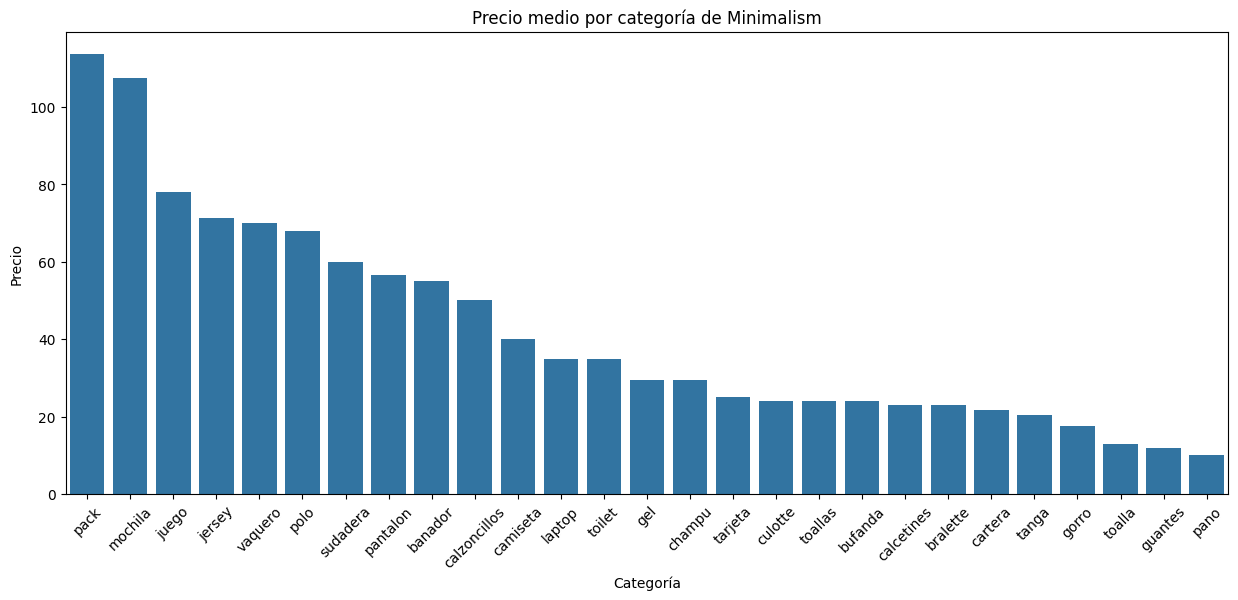

In [ ]:
df_minimalism_cat_precio = df_minimalism_cat.sort_values(by="precio", ascending=False)
plt.figure(figsize=(15, 6))

sns.barplot(data=df_minimalism_cat, x="categoria", y="precio", 
            order=df_minimalism_cat_precio["categoria"])

plt.xticks(rotation=45)
plt.title("Precio medio por categoría de Minimalism")
plt.xlabel("Categoría")
plt.ylabel("Precio")

plt.show()

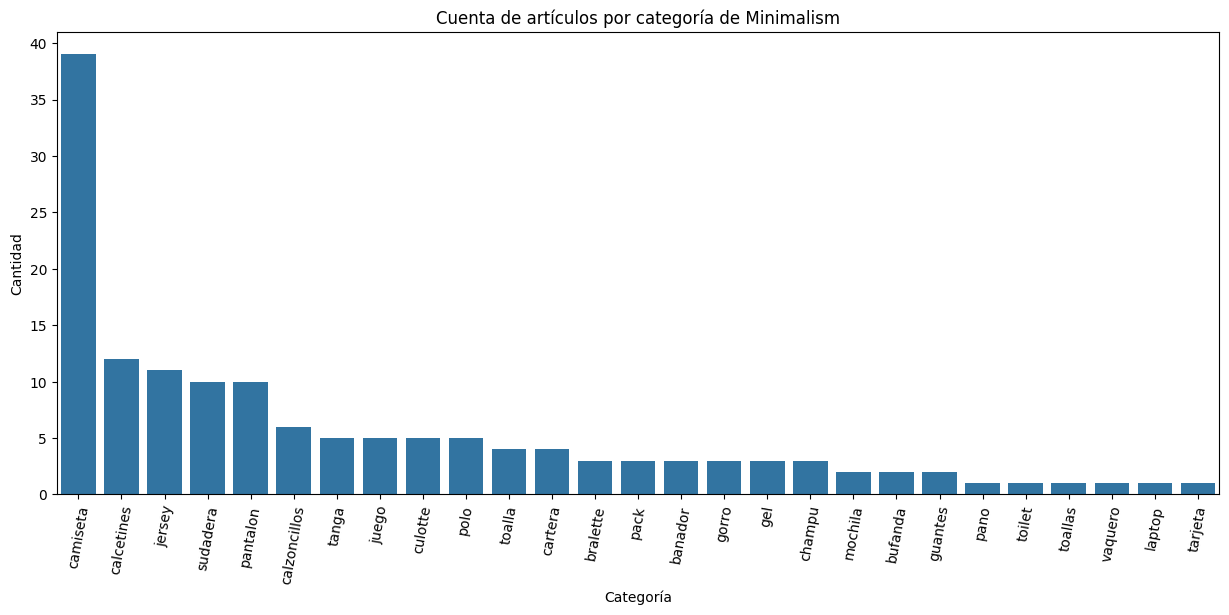

In [ ]:
category_order_count = df_minimalism['categoria'].value_counts().index
plt.figure(figsize=(15, 6))

sns.countplot(data=df_minimalism, x="categoria", order=category_order_count)

plt.xticks(rotation=80)
plt.title("Cuenta de artículos por categoría de Minimalism")
plt.xlabel("Categoría")
plt.ylabel("Cantidad")

plt.show()

In [55]:
#df_minimalism.to_csv("datos/minimalism_final.csv")

### Carga de DF a Google Sheets

In [ ]:
SCOPES = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive"
]

creds = Credentials.from_service_account_file("datos/client_secret.json", scopes=SCOPES)
client = gspread.authorize(creds)

df = pd.read_csv("datos/minimalism_final.csv")

drive_service = build('drive', 'v3', credentials=creds)

# Metadata para la Sheet
folder_id = '1P8WTL5shxMqT3g92WbzCzyNJUvNj_li0'  # folder ID (buscar en la url de la carpeta en drive)
file_metadata = {
    'name': "Minimalism",
    'mimeType': 'application/vnd.google-apps.spreadsheet',
    'parents': [folder_id]
}

# Crear la hoja en la carpeta
file = drive_service.files().create(body=file_metadata, fields='id').execute()
spreadsheet_id = file.get('id')

# Abrimos la hoja que acabmos de crear
spreadsheet = client.open_by_key(spreadsheet_id)
worksheet = spreadsheet.get_worksheet(0)  # Acceder a la primera página

# Cargar
set_with_dataframe(worksheet, df)

print("CSV subido a Google Sheets")

CSV subido a Google Sheets


## Web Scraping Ecoalf

### Captura de enlaces de Productos

In [ ]:
#Accedemos a la página
driver = webdriver.Chrome()
url = "https://ecoalf.com/collections/abrigos-y-chaquetas-210-hombre"
driver.get(url)
driver.maximize_window()
sleep(10)
driver.execute_script(f"window.scrollTo(0, {0,20});")

WebDriverWait(driver,5).until(EC.presence_of_element_located(("xpath","/html/body/div[1]/div/div[1]/div/div[2]/button[2]"))).click()
print("Hemos clickado en la x")

#Scrolleamos hasta el final para que cargue toda la página, de 200 en 200 para que cargue tranquilamente
altura_pagina = driver.execute_script("return document.body.scrollHeight")
for y in range(0, altura_pagina, 200):
    driver.execute_script(f"window.scrollTo(0, {y});")
    altura_pagina = driver.execute_script("return document.body.scrollHeight")
    sleep(2)

# Usamos BeautifulSoup para analizar el HTML de la página cargada
sopa_chaquetas_ecoalf = BeautifulSoup(driver.page_source, "html.parser")

# Extraemos todos los enlaces de chaquetas
nombre_chaqueta = sopa_chaquetas_ecoalf.find_all("a", class_="full-unstyled-link")

# Mostramos la cantidad de chaquetas encontradas
print(f"Cantidad de chaquetas encontradas: {len(nombre_chaqueta)}")

# Cerramos el navegador
driver.quit()

# #Sacamos las categorías y género
denominacion_url = url.rsplit("-")
genero = denominacion_url[-1]
categoria = denominacion_url[-3]

nombre_chaqueta = sopa_chaquetas_ecoalf.findAll("a", class_= "full-unstyled-link")

precios_chaquetas = sopa_chaquetas_ecoalf.find_all("div", class_="price__regular price-item price-item--regular")

#Le quitamos los headers a nombre_chaqueta
nombre_chaqueta = nombre_chaqueta[14:]
print(f"Hay {len(nombre_chaqueta)} chaquetas")
print(f"Hay {len(precios_chaquetas)} precios")

# Buscar todos los elementos <a> con la clase "full-unstyled-link"
enlaces = sopa_chaquetas_ecoalf.find_all("a", class_="full-unstyled-link")

# Extraer el atributo 'href' de cada enlace
links = [enlace['href'] for enlace in enlaces if 'href' in enlace.attrs]
links = links[14:]

links_completos = ["https://ecoalf.com" + i for i in links]


### Capturamos información de productos

In [ ]:
nombre_elemento =  []
precio_elemento =  []
detalles_elemento =  []

for single_link in links_completos:
    res_link = requests.get(single_link)
    sopa_elemento = BeautifulSoup(res_link.content, "html.parser")
    nombre_elemento.append(sopa_elemento.find_all("h1","product__title h4"))
    precio_elemento.append(sopa_elemento.find_all("div", class_="price__regular price-item price-item--regular"))
    detalles_elemento.append(sopa_elemento.find_all("div", class_="product__description rte"))

nombres_done = []
for lista in nombre_elemento:
    for i in lista:
        nombres_done.append(i.getText().strip())

precios_done = []
for lista in precio_elemento:
    for i in lista:
        precios_done.append(i.getText().strip())

detalles_element = []
for lista in detalles_elemento:
    for i in lista:
        detalles_element.append(i.getText().strip())

nueva_lista = []
for i in detalles_element:
        
    nueva_lista.append(i.split("\n"))
  
descripcion = []
tejido = []
for i in nueva_lista:
    descripcion.append(i[0])
    tejido.append(i[2])

len(tejido)

data = {"nombre": nombres_done,
        "precios": precios_done
        }
df_ecoalf = pd.DataFrame(data)

In [ ]:
df_reemplazo = df_ecoalf["nombre"]

def split_marca(text):
    palabra = text.split()
    return " ".join(palabra[:2])

df_reemplazo.apply(split_marca)
nombres_chaqueta = [chaqueta.lower().split(" ")[:2] for chaqueta in nombres_done]

nombres_chaqueta = [f"{i[0]} {i[1].capitalize()}" for i in nombres_chaqueta]
# listas_unidas = [" ".join(sublista) for sublista in nombres_chaqueta]

#print(nombres_chaqueta)

nombre_descripcion_dict = {}
for nombre in nombres_chaqueta:
    for des in descripcion:
        if nombre in des:
            nombre_descripcion_dict[nombre] = des
            pass  # Detener la búsqueda si ya se ha encontrado una coincidencia

nombre_descripcion_dict = {key.upper(): value for key, value in nombre_descripcion_dict.items()}

#print(nombre_descripcion_dict)

In [ ]:
df_ecoalf["nombre"] = df_ecoalf["nombre"].drop_duplicates()
df_ecoalf = df_ecoalf.dropna()

In [ ]:
# Función para buscar las claves del diccionario en el nombre y aplicar la descripción

def aplicar_descripcion(nombre, dic):
    # Recorre todas las claves del diccionario
    for key, descripcion in dic.items():
        if key in nombre:  # Si la clave está contenida en el nombre
            return descripcion  # Retorna la descripción
    return nombre  # Si no se encuentra, regresa el nombre original

# Aplicar la función a la columna 'nombre' del DataFrame usando lambda para pasar el diccionario
df_ecoalf['descripcion'] = df_ecoalf['nombre'].apply(lambda x: aplicar_descripcion(x, nombre_descripcion_dict))

In [ ]:
tejido = [i for i in tejido if "Tejido" in i]

In [ ]:
# Paso 1: Contar la frecuencia de cada material
frecuencias = Counter(tejido)

# Paso 2: Calcular la cantidad deseada para cada material en una lista de 74 elementos
target_total = 36
proporciones = {material: int(count * target_total / len(tejido)) for material, count in frecuencias.items()}

# Paso 3: Ajustar el total a 74 exactamente, en caso de desviaciones
ajuste = target_total - sum(proporciones.values())
if ajuste > 0:
    # Si faltan elementos, incrementar algunos en +1 hasta llegar a 74
    for material in random.sample(list(proporciones.keys()), ajuste):
        proporciones[material] += 1
elif ajuste < 0:
    # Si hay elementos de más, reducir algunos en -1 hasta llegar a 74
    for material in random.sample(list(proporciones.keys()), -ajuste):
        proporciones[material] -= 1

# Paso 4: Construir la lista final de materiales
materiales_reducidos = []
for material, count in proporciones.items():
    # Usamos sample si count <= frecuencia real, de lo contrario usamos choices para evitar error
    muestras_material = (random.sample([m for m in tejido if m == material], count)
                         if count <= frecuencias[material]
                         else random.choices([m for m in tejido if m == material], k=count))
    materiales_reducidos.extend(muestras_material)

print(len(materiales_reducidos))  # Debe imprimir exactamente 74
print(materiales_reducidos)

In [ ]:
df_ecoalf["genero"] = genero
df_ecoalf["mateiral"] = materiales_reducidos
#df_ecoalf.to_csv("datos/df_ecoalf.csv")

In [14]:
df_ecoalf = pd.read_csv("datos/df_ecoalf.csv", index_col=0)

In [15]:
df_ecoalf["precios"] = df_ecoalf["precios"].str.replace("€","")
df_ecoalf["precios"] = df_ecoalf["precios"].str.replace(",",".")
df_ecoalf["precios"] = df_ecoalf["precios"].astype(float)

In [16]:
df_ecoalf.head(3)

,nombre,precios,descripcion,genero,mateiral
0,CHAQUETA VENUE AZUL MARINO,219.9,La chaqueta Venue está hecha de poliéster reci...,hombre,Tejido principal: 100% poliéster reciclado
2,CHAQUETA GRAYS AZUL MARINO,229.9,La chaqueta Grays es monomaterial y está hecha...,hombre,Tejido principal: 100% poliéster reciclado
4,ABRIGO LIVORNO NEGRO,399.9,El abrigo Livorno está hecho con nuestro Hilo ...,hombre,Tejido principal: 100% poliéster reciclado


In [17]:
df_ecoalf_chaquetas = df_ecoalf[df_ecoalf['nombre'].str.contains("chaqueta", case=False, na=False)]
df_minimalism_jer_sud = df_minimalism[(df_minimalism["categoria"] == "jersey") | (df_minimalism["categoria"] == "sudadera")]

In [22]:
print(df_ecoalf_chaquetas["precios"].mean())
print(df_minimalism["precio"].mean())
print(df_minimalism_jer_sud["precio"].mean())
print(df_minimalism["valoracion"].mean())
print(df_minimalism["cant_valoraciones"].mean())

214.8190476190476
44.301095890410956
65.95238095238095
4.675229357798165
84.91743119266054


- El precio promedio de las chaquetas de ECOALF es de 214 euros.
- El precio medio de todos los productos de Minimalism es de 44 euros.
- El precio medio de los jerseys y las sudaderas de Minimalism es de 66 euros.
- La valoración promedio de Minimalism es 4,68.
- Cada producto de Minimalism tiene en promedio 85 reseñas.

### Subimos Ecoalf a Google Sheets

In [ ]:
SCOPES = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive"
]

creds = Credentials.from_service_account_file("datos/client_secret.json", scopes=SCOPES)
client = gspread.authorize(creds)

drive_service = build('drive', 'v3', credentials=creds)

folder_id = '1P8WTL5shxMqT3g92WbzCzyNJUvNj_li0'
file_metadata = {
    'name': "ECOALF",
    'mimeType': 'application/vnd.google-apps.spreadsheet',
    'parents': [folder_id] 
}

file = drive_service.files().create(body=file_metadata, fields='id').execute()
spreadsheet_id = file.get('id')

spreadsheet = client.open_by_key(spreadsheet_id)
worksheet = spreadsheet.get_worksheet(0) 

set_with_dataframe(worksheet, df_ecoalf)

print("CSV subido a Google Sheets")

CSV subido a Google Sheets


## Carhartt

In [ ]:
def htmls_carhartt(lista_paths):
    data = []
    
    for path in lista_paths:
        with open(path, "r", encoding="utf-8") as file:
            soup = BeautifulSoup(file, "html.parser")
        
        script_tag = soup.find("script", string=re.compile(r"googleImpressions.push"))
        
        name_pattern = re.compile(r"'name':\s*\"(.*?)\"")
        price_pattern = re.compile(r"parseFloat\(\"(.*?)\"")
        brand_pattern = re.compile(r"'brand':\s*'(.*?)'")
        category_pattern = re.compile(r"'category':\s*'(.*?)'")
        list_pattern = re.compile(r"'list':\s*'(.*?)'")
        
        if script_tag:
            products = script_tag.text.split("googleImpressions.push")
            
            for product in products[1:]:
                name = name_pattern.search(product)
                price = price_pattern.search(product)
                brand = brand_pattern.search(product)
                category = category_pattern.search(product)
                product_list = list_pattern.search(product)
                
                if name and price and brand and category and product_list:
                    data.append({
                        "producto": name.group(1),
                        "precio": price.group(1).replace(",", ".").replace(".replace(/./g. '.'))",""),
                        "marca": brand.group(1),
                        "categoria": category.group(1),
                        #"lista": product_list.group(1)
                    })
    
    df = pd.DataFrame(data)
    
    df[['producto', 'color']] = df['producto'].str.split(' / ', expand=True)
    df['categoria'] = df['categoria'].replace({
        "men-jackets-winter": "abrigo",
        "men-jackets-vests": "chaleco",
        "men-jackets-parka": "parka",
        "men-jackets-outdoor": "abrigo",
        "men-jackets-coats": "chaqueta",
        "men-jackets-shirt": "chaqueta",
        "men-jackets-work": "chaqueta",
        "men-jackets-fleece": "forro polar",
        "men-jackets-lightweight": "chaqueta"
    })
    
    df = df[["marca", "categoria", "producto", "color", "precio"]]
    
    return df

In [13]:
paths_carhartt = ["datos/carhartt.html"]
df_carhartt = htmls_carhartt(paths_carhartt)
df_carhartt["categoria"].unique()

/var/folders/yj/y1bv8zk12j11bnjq1hc6x_d80000gn/T/ipykernel_82059/2586869949.py:8: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  script_tag = soup.find("script", text=re.compile(r"googleImpressions.push"))


array(['abrigo', 'chaleco', 'parka', 'chaqueta', 'forro polar'],
      dtype=object)

In [207]:
df_carhartt.head(5)

,marca,categoria,producto,color,precio
0,Carhartt,abrigo,Springfield Vest Peanut,Chocolate,179.00
1,Carhartt,chaleco,Rayley Vest Peanut,None,199.00
2,Carhartt,chaleco,Rayley Vest Black,None,199.00
3,Carhartt,abrigo,"Springfield Vest Camo Duck, Grey",Hamilton Brown,199.00
4,Carhartt,parka,Hooded Olten Parka Duck Green,None,299.00


In [208]:
df_carhartt_chaq = df_carhartt[df_carhartt["categoria"] == "chaqueta"]
df_carhartt_chaq["precio"] = df_carhartt_chaq["precio"].astype(float)
df_carhartt_chaq["precio"].mean()

/var/folders/yj/y1bv8zk12j11bnjq1hc6x_d80000gn/T/ipykernel_73269/4121165494.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_carhartt_chaq["precio"] = df_carhartt_chaq["precio"].astype(float)


np.float64(214.45454545454547)

El precio medio de las chaquetas en Carhartt es de 214 euros.

In [209]:
df_carhartt_detroit = df_carhartt[df_carhartt['producto'].str.contains("detroit", case=False, na=False)]
df_carhartt_detroit["precio"] = df_carhartt_detroit["precio"].astype(float)
df_carhartt_detroit["precio"].mean()

/var/folders/yj/y1bv8zk12j11bnjq1hc6x_d80000gn/T/ipykernel_73269/3567525159.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_carhartt_detroit["precio"] = df_carhartt_detroit["precio"].astype(float)


np.float64(214.0)

In [226]:
df_carhartt.head(1)

,marca,categoria,producto,color,precio
0,Carhartt,abrigo,Springfield Vest Peanut,Chocolate,179.00


In [231]:
df_carhartt["precio"]=df_carhartt["precio"].astype(float)

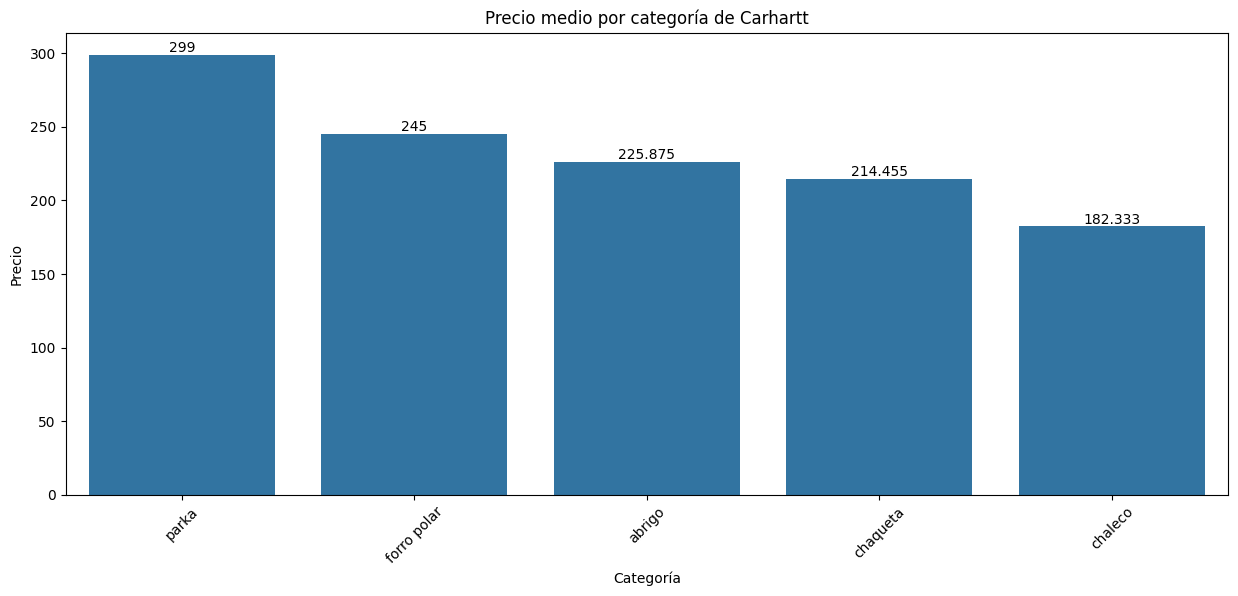

In [235]:
df_carhartt_cat = df_carhartt.groupby("categoria")[["precio"]].mean().reset_index()
df_carhartt_cat_precio = df_carhartt_cat.sort_values(by="precio", ascending=False)
plt.figure(figsize=(15, 6))

ax = sns.barplot(data=df_carhartt_cat, x="categoria", y="precio", 
            order=df_carhartt_cat_precio["categoria"])

for i in ax.containers:
    ax.bar_label(i,)

plt.xticks(rotation=45)
plt.title("Precio medio por categoría de Carhartt")
plt.xlabel("Categoría")
plt.ylabel("Precio")

plt.show()

### Subimos Carhartt a Google Sheets

In [ ]:
SCOPES = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive"
]

creds = Credentials.from_service_account_file("datos/client_secret.json", scopes=SCOPES)
client = gspread.authorize(creds)

drive_service = build('drive', 'v3', credentials=creds)

folder_id = '1P8WTL5shxMqT3g92WbzCzyNJUvNj_li0'
file_metadata = {
    'name': "Carhartt",
    'mimeType': 'application/vnd.google-apps.spreadsheet',
    'parents': [folder_id]
}

file = drive_service.files().create(body=file_metadata, fields='id').execute()
spreadsheet_id = file.get('id')

spreadsheet = client.open_by_key(spreadsheet_id)
worksheet = spreadsheet.get_worksheet(0)

set_with_dataframe(worksheet, df_carhartt)

print("CSV subido a Google Sheets")

CSV subido a Google Sheets
